In [36]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torchinfo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from timm.models.vision_transformer import VisionTransformer

from local_python.dataset_util import (
    create_dataloaders,
)
from local_python.feature_evaluation import calculate_scores
from local_python.general_utils import (
    load_model,
    load_pd_from_json,
    load_values_from_previous_epochs,
    print_parameters,
    set_seed,
)

from lora_vit.models import LoRA_ViT_timm
from ssl_library.src.models.fine_tuning.classifiers import LinearClassifier

In [37]:
configuration_csv_path = "./configs/finetune-configuration.csv"
learning_rate = 1e-4

In [38]:
df_config = pd.read_csv(configuration_csv_path)
df_config

,seed,strategy,dataset_path,checkpoint_path
0,1,concat_1,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...
1,1,concat_2,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...
2,1,concat_3,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...
3,1,concat_4,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...
4,1,lora_1,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...
5,1,lora_2,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...
6,1,lora_3,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...
7,1,lora_4,../data_splits/HAM10000_split.csv,../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_...


In [42]:
def prepare_model(checkpoint_path, strategy, num_classes, image_shape):
    strategy_params = strategy.split("_")

    if "concat" == strategy_params[0]:
        rank = int(strategy_params[1])
        model = load_model(checkpoint_path, freeze=False, use_ssl_library=True)
        params = list(model.parameters())
        for param in params[: len(params) - rank]:
            param.requires_grad = False
        summary = torchinfo.summary(model, image_shape, batch_dim=0)
        last_output = summary.summary_list[-1].output_size[-1]
        model.head = LinearClassifier(
            last_output,
            num_labels=num_classes,
            use_dropout_in_head=True,
            large_head=False,
            use_bn=True,
        )
    elif "lora" == strategy_params[0]:
        rank = int(strategy_params[1])
        model = load_model(checkpoint_path, freeze=True, use_ssl_library=False)
        summary = torchinfo.summary(model, image_shape, batch_dim=0)
        last_output = summary.summary_list[-1].output_size[-1]
        assert hasattr(model, "blocks"), f"Unknown model type: {type(model)}"
        model.head = LinearClassifier(
            last_output,
            num_labels=num_classes,
            use_dropout_in_head=True,
            large_head=False,
            use_bn=True,
        )
        model = LoRA_ViT_timm(vit_model=model, r=rank, alpha=4)
    else:
        assert False, f"Unknown strategy: {strategy}"

    return model

def eval(model, data_loader_valid, sample=False, verbose=False):
    model = model.to(device)
    model.eval()

    label_tensor = torch.zeros(0)
    pred_tensor = torch.zeros(0)

    with torch.no_grad():
        for images, targets in tqdm(data_loader_valid):
            label_tensor = torch.cat([label_tensor, targets])
            images = images.to(device)
            targets = torch.as_tensor(targets).to(device)

            outputs = model(images)
            # loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)
            pred_tensor = torch.cat([pred_tensor, preds.view(-1).cpu()])
            if verbose:
                for output, target in zip(outputs, targets):
                    probs = softmax(output.cpu().detach().numpy())
                    max_idx = np.argmax(probs)
                    print(
                        f"Actual class {label_map[target]}, predicted class {max_idx} with probability {probs[max_idx]} "
                    )
            if sample:
                break
    return label_tensor.numpy(), pred_tensor.numpy()

def train_eval(
    model, optimizer, criterion, start_epoch, end_epoch, dataloaders, loss_file_path, best_loss = None
):
    model = model.to(device)
    for epoch in range(start_epoch, end_epoch):
        model.train()
        print(f"Training epoch {epoch}")
        with open(loss_file_path, "a") as detaillog:
            for i, (images, targets) in enumerate(tqdm(dataloaders["train"])):
                images = images.to(device)
                targets = torch.as_tensor(targets).to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)

                line = {}
                line["epoch"] = epoch
                line["iteration"] = i
                line["loss"] = loss.item()
                line["set"] = "train"
                json.dump(line, detaillog, indent=2)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        torch.save(
            model.state_dict(),
            os.path.join(run_path, f"checkpoint_latest.pth"),
        )

        model.eval()
        valid_loss = []
        with torch.no_grad():
            with open(loss_file_path, "a") as detaillog:
                for i, (images, targets) in enumerate(tqdm(dataloaders["valid"])):
                    images = images.to(device)
                    targets = torch.as_tensor(targets).to(device)

                    outputs = model(images)
                    loss = criterion(outputs, targets)
                    valid_loss.append(loss.item())

                    line = {}
                    line["epoch"] = epoch
                    line["iteration"] = i
                    line["loss"] = valid_loss[-1]
                    line["set"] = "valid"
                    json.dump(line, detaillog, indent=2)
        
        mean_loss = np.array(valid_loss).mean()
        if best_loss is None or mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(
                model.state_dict(),
                os.path.join(run_path, f"checkpoint_best.pth"),
            )

def get_dataset_info(strategy, dataset_path):
    batch_size = 64
    if strategy.startswith("lora"):
        batch_size = 32

    dataloaders = create_dataloaders(dataset_path, batch_size=batch_size)
    train_class_counts = dataloaders["train"].dataset.get_class_counts()
    print(f"Train class (im)balance: {train_class_counts}")
    num_classes = len(train_class_counts)
    images, _ = next(iter(dataloaders["valid"]))
    image_shape = images.shape[1:]
    class_weights_tensor = torch.tensor(
        1.0 / np.array(list(train_class_counts.values())), dtype=torch.float
    )
    return image_shape, num_classes, dataloaders, class_weights_tensor

In [40]:
assert torch.cuda.is_available()
n_devices = torch.cuda.device_count()
for i in range(0, n_devices):
    print(torch.cuda.get_device_name(i))

device = torch.device("cuda")

NVIDIA GeForce GTX 960


In [43]:
for _, row in df_config.iterrows():
    seed = row["seed"]
    set_seed(seed)

    checkpoint_path = row["checkpoint_path"]
    model_name = os.path.splitext(os.path.basename(checkpoint_path))[0].replace(
        "_headless", ""
    )

    dataset_path = row["dataset_path"]
    dataset_name = os.path.splitext(os.path.basename(dataset_path))[0].replace(
        "_split", ""
    )

    strategy = row["strategy"]

    run_path = os.path.join("../runs/", dataset_name, model_name, f"{strategy}_{seed}")
    if not os.path.exists(run_path):
        os.makedirs(run_path)
    print(f"Results will be saved to {run_path}")
    
    image_shape, num_classes, dataloaders, class_weights_tensor = get_dataset_info(strategy, dataset_path)
    model = prepare_model(checkpoint_path, strategy, num_classes, image_shape)
    print_parameters(model)

    class_weights_tensor = class_weights_tensor.to(device)
    loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor, reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    (loss_file_path, latest_epoch, best_loss) = load_values_from_previous_epochs(run_path)

    checkpoint_path = os.path.join(run_path, f"checkpoint_latest.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint, strict=True)

    checkpoint_path = os.path.join(run_path, f"checkpoint_best.pth")
    if not os.path.exists(checkpoint_path):
        best_loss = None # reset    

    start_epoch = latest_epoch + 1
    end_epoch = start_epoch + 30

    train_eval(
        model,
        optimizer,
        loss_function,
        start_epoch,
        end_epoch,
        dataloaders,
        loss_file_path,
        best_loss = best_loss,
    )*

Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\concat_1_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Trainable parameters: 7111/5531335
Training epoch 0


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Training epoch 1


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 2


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 3


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 4


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 5


100%|██████████| 18/18 [00:12<00:00,  1.40it/s]


Training epoch 6


100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


Training epoch 7


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 8


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 9


100%|██████████| 18/18 [00:12<00:00,  1.40it/s]


Training epoch 10


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 11


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 12


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 13


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 14


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 15


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 16


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 17


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 18


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 19


100%|██████████| 18/18 [00:12<00:00,  1.40it/s]


Training epoch 20


100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


Training epoch 21


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 22


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 23


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 24


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 25


100%|██████████| 18/18 [00:12<00:00,  1.40it/s]


Training epoch 26


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 27


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 28


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 29


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\concat_2_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Trainable parameters: 7303/5531335
Training epoch 0


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 1


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 2


100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


Training epoch 3


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 4


100%|██████████| 18/18 [00:12<00:00,  1.40it/s]


Training epoch 5


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 6


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 7


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 8


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 9


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 10


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 11


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 12


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 13


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 14


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 15


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 16


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 17


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 18


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 19


100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


Training epoch 20


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 21


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 22


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Training epoch 23


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 24


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 25


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 26


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 27


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 28


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 29


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\concat_3_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Trainable parameters: 7495/5531335
Training epoch 0


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 1


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Training epoch 2


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 3


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 4


100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


Training epoch 5


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 6


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 7


100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


Training epoch 8


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 9


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 10


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 11


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 12


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 13


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 14


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 15


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 16


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 17


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 18


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 19


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 20


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 21


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 22


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 23


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 24


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 25


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 26


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 27


100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


Training epoch 28


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 29


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\concat_4_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Trainable parameters: 154951/5531335
Training epoch 0


100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


Training epoch 1


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 2


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 3


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Training epoch 4


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 5


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 6


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 7


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 8


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 9


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Training epoch 10


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 11


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 12


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 13


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 14


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 15


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Training epoch 16


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 17


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 18


100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Training epoch 19


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 20


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Training epoch 21


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Training epoch 22


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 23


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Training epoch 24


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Training epoch 25


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 26


100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


Training epoch 27


100%|██████████| 18/18 [00:13<00:00,  1.34it/s]


Training epoch 28


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Training epoch 29


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\lora_1_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'model.'
Trainable parameters: 9216/5535367
Training epoch 0


100%|██████████| 35/35 [00:14<00:00,  2.47it/s]


Training epoch 1


100%|██████████| 35/35 [00:13<00:00,  2.63it/s]


Training epoch 2


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 3


100%|██████████| 35/35 [00:14<00:00,  2.49it/s]


Training epoch 4


100%|██████████| 35/35 [00:13<00:00,  2.66it/s]


Training epoch 5


100%|██████████| 35/35 [00:13<00:00,  2.66it/s]


Training epoch 6


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 7


100%|██████████| 35/35 [00:13<00:00,  2.65it/s]


Training epoch 8


100%|██████████| 35/35 [00:13<00:00,  2.62it/s]


Training epoch 9


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 10


100%|██████████| 35/35 [00:14<00:00,  2.48it/s]


Training epoch 11


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 12


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 13


100%|██████████| 35/35 [00:13<00:00,  2.50it/s]


Training epoch 14


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 15


100%|██████████| 35/35 [00:13<00:00,  2.62it/s]


Training epoch 16


100%|██████████| 35/35 [00:13<00:00,  2.63it/s]


Training epoch 17


100%|██████████| 35/35 [00:13<00:00,  2.62it/s]


Training epoch 18


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 19


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 20


100%|██████████| 35/35 [00:14<00:00,  2.40it/s]


Training epoch 21


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 22


100%|██████████| 35/35 [00:13<00:00,  2.63it/s]


Training epoch 23


100%|██████████| 35/35 [00:13<00:00,  2.55it/s]


Training epoch 24


100%|██████████| 35/35 [00:13<00:00,  2.57it/s]


Training epoch 25


100%|██████████| 35/35 [00:13<00:00,  2.68it/s]


Training epoch 26


100%|██████████| 35/35 [00:13<00:00,  2.68it/s]


Training epoch 27


100%|██████████| 35/35 [00:13<00:00,  2.67it/s]


Training epoch 28


100%|██████████| 35/35 [00:13<00:00,  2.69it/s]


Training epoch 29


100%|██████████| 35/35 [00:13<00:00,  2.57it/s]


Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\lora_2_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'model.'
Trainable parameters: 18432/5544583
Training epoch 0


100%|██████████| 35/35 [00:13<00:00,  2.68it/s]


Training epoch 1


100%|██████████| 35/35 [00:13<00:00,  2.65it/s]


Training epoch 2


100%|██████████| 35/35 [00:13<00:00,  2.68it/s]


Training epoch 3


100%|██████████| 35/35 [00:13<00:00,  2.55it/s]


Training epoch 4


100%|██████████| 35/35 [00:12<00:00,  2.79it/s]


Training epoch 5


100%|██████████| 35/35 [00:12<00:00,  2.82it/s]


Training epoch 6


100%|██████████| 35/35 [00:12<00:00,  2.83it/s]


Training epoch 7


100%|██████████| 35/35 [00:12<00:00,  2.85it/s]


Training epoch 8


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Training epoch 9


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Training epoch 10


100%|██████████| 35/35 [00:12<00:00,  2.79it/s]


Training epoch 11


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Training epoch 12


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Training epoch 13


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Training epoch 14


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Training epoch 15


100%|██████████| 35/35 [00:12<00:00,  2.82it/s]


Training epoch 16


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Training epoch 17


100%|██████████| 35/35 [00:12<00:00,  2.81it/s]


Training epoch 18


100%|██████████| 35/35 [00:12<00:00,  2.82it/s]


Training epoch 19


100%|██████████| 35/35 [00:12<00:00,  2.70it/s]


Training epoch 20


100%|██████████| 35/35 [00:13<00:00,  2.59it/s]


Training epoch 21


100%|██████████| 35/35 [00:13<00:00,  2.69it/s]


Training epoch 22


100%|██████████| 35/35 [00:12<00:00,  2.73it/s]


Training epoch 23


100%|██████████| 35/35 [00:13<00:00,  2.60it/s]


Training epoch 24


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Training epoch 25


100%|██████████| 35/35 [00:12<00:00,  2.77it/s]


Training epoch 26


100%|██████████| 35/35 [00:13<00:00,  2.66it/s]


Training epoch 27


100%|██████████| 35/35 [00:13<00:00,  2.54it/s]


Training epoch 28


100%|██████████| 35/35 [00:12<00:00,  2.75it/s]


Training epoch 29


100%|██████████| 35/35 [00:12<00:00,  2.83it/s]


Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\lora_3_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'model.'
Trainable parameters: 27648/5553799
Training epoch 0


100%|██████████| 35/35 [00:12<00:00,  2.74it/s]


Training epoch 1


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Training epoch 2


100%|██████████| 35/35 [00:13<00:00,  2.59it/s]


Training epoch 3


100%|██████████| 35/35 [00:15<00:00,  2.33it/s]


Training epoch 4


100%|██████████| 35/35 [00:12<00:00,  2.73it/s]


Training epoch 5


100%|██████████| 35/35 [00:14<00:00,  2.40it/s]


Training epoch 6


100%|██████████| 35/35 [00:12<00:00,  2.82it/s]


Training epoch 7


100%|██████████| 35/35 [00:12<00:00,  2.76it/s]


Training epoch 8


100%|██████████| 35/35 [00:12<00:00,  2.75it/s]


Training epoch 9


100%|██████████| 35/35 [00:12<00:00,  2.80it/s]


Training epoch 10


100%|██████████| 35/35 [00:13<00:00,  2.69it/s]


Training epoch 11


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Training epoch 12


100%|██████████| 35/35 [00:12<00:00,  2.77it/s]


Training epoch 13


100%|██████████| 35/35 [00:12<00:00,  2.72it/s]


Training epoch 14


100%|██████████| 35/35 [00:14<00:00,  2.44it/s]


Training epoch 15


100%|██████████| 35/35 [00:15<00:00,  2.21it/s]


Training epoch 16


100%|██████████| 35/35 [00:13<00:00,  2.62it/s]


Training epoch 17


100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


Training epoch 18


100%|██████████| 35/35 [00:12<00:00,  2.75it/s]


Training epoch 19


100%|██████████| 35/35 [00:13<00:00,  2.57it/s]


Training epoch 20


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Training epoch 21


100%|██████████| 35/35 [00:12<00:00,  2.77it/s]


Training epoch 22


100%|██████████| 35/35 [00:12<00:00,  2.74it/s]


Training epoch 23


100%|██████████| 35/35 [00:14<00:00,  2.39it/s]


Training epoch 24


100%|██████████| 35/35 [00:16<00:00,  2.17it/s]


Training epoch 25


100%|██████████| 35/35 [00:12<00:00,  2.76it/s]


Training epoch 26


100%|██████████| 35/35 [00:16<00:00,  2.17it/s]


Training epoch 27


100%|██████████| 35/35 [00:13<00:00,  2.52it/s]


Training epoch 28


100%|██████████| 35/35 [00:14<00:00,  2.46it/s]


Training epoch 29


100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


Setting seed to 1
Results will be saved to ../runs/HAM10000\ViT_T16-Plant_SSL_Dino\lora_4_1
Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'model.'
Trainable parameters: 36864/5563015
Training epoch 0


100%|██████████| 35/35 [00:12<00:00,  2.75it/s]


Training epoch 1


100%|██████████| 35/35 [00:12<00:00,  2.73it/s]


Training epoch 2


100%|██████████| 35/35 [00:13<00:00,  2.55it/s]


Training epoch 3


100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


Training epoch 4


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Training epoch 5


100%|██████████| 35/35 [00:12<00:00,  2.77it/s]


Training epoch 6


100%|██████████| 35/35 [00:15<00:00,  2.27it/s]


Training epoch 7


100%|██████████| 35/35 [00:12<00:00,  2.70it/s]


Training epoch 8


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Training epoch 9


100%|██████████| 35/35 [00:13<00:00,  2.67it/s]


Training epoch 10


100%|██████████| 35/35 [00:12<00:00,  2.70it/s]


Training epoch 11


100%|██████████| 35/35 [00:14<00:00,  2.36it/s]


Training epoch 12


100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


Training epoch 13


100%|██████████| 35/35 [00:15<00:00,  2.32it/s]


Training epoch 14


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Training epoch 15


100%|██████████| 35/35 [00:12<00:00,  2.70it/s]


Training epoch 16


100%|██████████| 35/35 [00:14<00:00,  2.43it/s]


Training epoch 17


100%|██████████| 35/35 [00:14<00:00,  2.46it/s]


Training epoch 18


100%|██████████| 35/35 [00:12<00:00,  2.69it/s]


Training epoch 19


100%|██████████| 35/35 [00:12<00:00,  2.74it/s]


Training epoch 20


100%|██████████| 35/35 [00:14<00:00,  2.44it/s]


Training epoch 21


100%|██████████| 35/35 [00:13<00:00,  2.63it/s]


Training epoch 22


100%|██████████| 35/35 [00:13<00:00,  2.68it/s]


Training epoch 23


100%|██████████| 35/35 [00:12<00:00,  2.72it/s]


Training epoch 24


100%|██████████| 35/35 [00:12<00:00,  2.75it/s]


Training epoch 25


100%|██████████| 35/35 [00:12<00:00,  2.71it/s]


Training epoch 26


100%|██████████| 35/35 [00:14<00:00,  2.43it/s]


Training epoch 27


100%|██████████| 35/35 [00:15<00:00,  2.29it/s]


Training epoch 28


100%|██████████| 35/35 [00:14<00:00,  2.43it/s]


Training epoch 29


100%|██████████| 35/35 [00:14<00:00,  2.46it/s]


In [35]:
dataset_name = "HAM10000"
dataset_path = os.path.join(f"../data_splits/{dataset_name}_split.csv")

checkpoint_path = "../model_weights/vit_t16_v2/ViT_T16-ImageNet_1k_SSL_Dino_headless.pth"

labels = None 
preds = None

strategy = ["concat", "lora"][1]
image_shape, num_classes, dataloaders = get_dataset_info(strategy, dataset_path)

parentdir = f"../runs/{dataset_name}/ViT_T16-ImageNet_1k_SSL_Dino/"
for subdir in os.listdir(parentdir):
    if not subdir.startswith(strategy):
        continue

    model = prepare_model(checkpoint_path, subdir, num_classes, image_shape)

    checkpoint_best =  os.path.join(parentdir, subdir, "checkpoint_best.pth")
    checkpoint = torch.load(checkpoint_best, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint, strict=True)
    
    labels, preds = eval(model, dataloaders["valid"])

    metrics = calculate_scores(
        labels,
        preds,
        {},
    )
    print(metrics)

    # break
    # plot_loss_txt(os.path.join(parentdir, subdir, "loss.txt"))
    # plt.title(subdir)


Set train size: 8908
Set valid size: 1103
Train class (im)balance: {'bkl': 971, 'nv': 5969, 'df': 103, 'mel': 992, 'vasc': 128, 'bcc': 455, 'akiec': 290}
Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'model.'


c:\workspace\thesis\.venv\lib\site-packages\timm\models\vision_transformer.py:86: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
100%|██████████| 35/35 [00:13<00:00,  2.64it/s]


{'accuracy': 0.700815956482321, 'balanced_accuracy': 0.6578690394638379, 'f1_weighted': 0.727139046424939, 'f1_micro': 0.700815956482321, 'f1_macro': 0.5827577125415873}
Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'model.'


100%|██████████| 35/35 [00:13<00:00,  2.68it/s]


{'accuracy': 0.7198549410698096, 'balanced_accuracy': 0.6714438644430867, 'f1_weighted': 0.742547324287125, 'f1_micro': 0.7198549410698097, 'f1_macro': 0.5895753485185479}
Loading vit_tiny_patch16_224 from timm-library
Ignoring prefix 'model.'


100%|██████████| 35/35 [00:13<00:00,  2.57it/s]

{'accuracy': 0.257479601087942, 'balanced_accuracy': 0.15221782695172217, 'f1_weighted': 0.3381619754493062, 'f1_micro': 0.257479601087942, 'f1_macro': 0.1304618912454521}


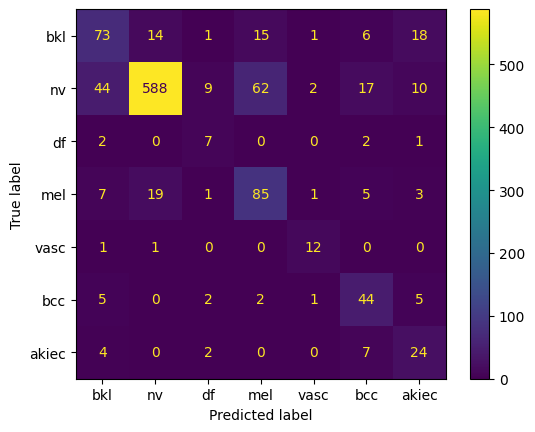

In [33]:
label_map = dataloaders["train"].dataset.get_label_map()
label_names = [
    k for k, v in label_map.items() if (v in labels or v in preds)
]
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
cm_display.plot()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [21]:
labels

array([0., 3., 1., ..., 1., 1., 6.], dtype=float32)

In [22]:
preds

array([0., 3., 3., ..., 1., 1., 6.], dtype=float32)